In [61]:
import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitty_dir = 'kitti/drives'
kitty_date = '2011_09_26'
kitty_drive = '0002'

data = pykitti.raw(kitty_dir, kitty_date, kitty_drive)

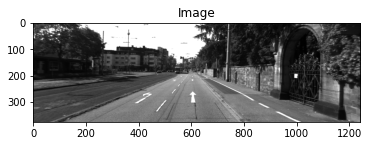

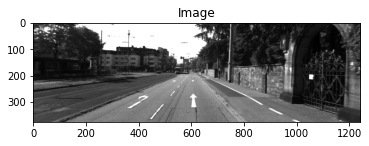

In [62]:
img1 = np.array(data.get_cam0(50))
img2 = np.array(data.get_cam0(51))
img3 = np.array(data.get_cam0(52))
K = data.calib.K_cam0

plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image')
plt.show()
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

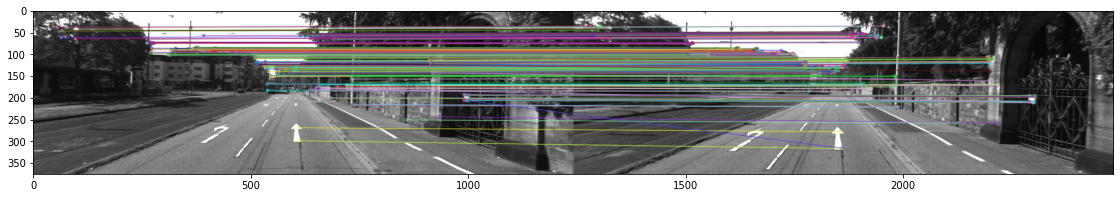

Keeping 120/348 points that match the fundamental matrix


array([[-3.81770942e-03, -2.76868273e+02, -2.57759220e+01],
       [ 2.87332873e+02, -2.61995216e+00, -1.90207309e+03],
       [ 2.67767887e+01,  1.90302478e+03,  1.08742304e-01]])

In [63]:
def detect_matches_and_E(img1, img2, draw=True):
	# Find Matches
	# From: https://stackoverflow.com/a/33670318
	orb = cv2.ORB_create()
	kp1, des1 = orb.detectAndCompute(img1, None)
	kp2, des2 = orb.detectAndCompute(img2, None)
	bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
	matches = bf.match(des1, des2)
	matches = sorted(matches, key=lambda x: x.distance)

	if draw:
		match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
		plt.figure(figsize=(30, 3))
		plt.imshow(match_img)
		plt.show()

	# Find Points
	# From book
	imgpts1 = []
	imgpts2 = []
	for match in matches:
		imgpts1.append(kp1[match.queryIdx].pt)
		imgpts2.append(kp2[match.trainIdx].pt)
	
	points1 = np.array(imgpts1)
	points2 = np.array(imgpts2)
	
	F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 100000)
	E = K.T @ F @ K
	
	if draw:
		print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")

	status_mask = status_mask[:, 0] == 1
	points1 = points1[status_mask]
	points2 = points2[status_mask]

	return points1, points2, matches, E

points1, points2, matches, E = detect_matches_and_E(img1, img2)

E

In [64]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:,np.newaxis]))
	return P

P1 = P_from_E(E)
# P0 is assumed to be fixed
P = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])

P, P1

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[ 0.9566098 , -0.02692886,  0.29012502,  0.98949542],
        [-0.02712061, -0.99962652, -0.00336047, -0.01340091],
        [ 0.29010716, -0.00465371, -0.95698285,  0.14394178]]))

## Triangulation

In [65]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P and P1 do)
	u: np.array, # point in image 1: (x, y, 1)
	P: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[ u[0]*P[2,0]-P[0,0],    u[0]*P[2,1]-P[0,1],    u[0]*P[2,2]-P[0,2]],
		[ u[1]*P[2,0]-P[1,0],    u[1]*P[2,1]-P[1,1],    u[1]*P[2,2]-P[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u[0]*P[2, 3]-P[0, 3]),
		-(u[1]*P[2, 3]-P[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [66]:
from collections import namedtuple

class CloudPoint(namedtuple('CloudPoint', ['point_3d', 'point_2d_2'])):
	def __eq__(self, other):
		return np.array_equal(self.point_3d, other.point_3d) and np.array_equal(self.point_2d_2, other.point_2d_2)

# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	point_cloud = []
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u, P, u1, P1)
		cloudpoint = CloudPoint(X[0:3], pt_set2[i])

		if cloudpoint in point_cloud:
			continue

		# Calculate reprojection error
		xPt_img = K @ P1 @ X
		xPt_img_normalized = xPt_img[0:1] / xPt_img[2]
		reproj_error.append(np.linalg.norm(xPt_img_normalized))
		point_cloud.append(cloudpoint)
	
	# Return mean reprojection error
	return np.mean(reproj_error), point_cloud


err, point_cloud = triangulate_points(points1, points2, K, P, P1)
print("Mean reprojection error:", err)
point_cloud


Mean reprojection error: 490.2421318576487


[CloudPoint(point_3d=array([-1.14876347, -0.50257288,  4.29218668]), point_2d_2=array([416.44802856,  88.12800598])),
 CloudPoint(point_3d=array([ 0.67462966,  0.243455  , -7.93701053]), point_2d_2=array([548.22680664, 150.49363708])),
 CloudPoint(point_3d=array([  5.32185684,   3.35603177, -38.61262813]), point_2d_2=array([512.17926025, 109.90081787])),
 CloudPoint(point_3d=array([-1.10645862, -0.44786069,  4.0120654 ]), point_2d_2=array([410.57290649,  92.06786346])),
 CloudPoint(point_3d=array([ 0.38051283,  0.36368421, -5.90220271]), point_2d_2=array([564.4800415 , 128.16000366])),
 CloudPoint(point_3d=array([-0.79403574, -0.18902536,  1.93039971]), point_2d_2=array([312.76803589, 101.95201111])),
 CloudPoint(point_3d=array([ 0.46051236,  0.35507085, -6.41975502]), point_2d_2=array([559.87207031, 132.7104187 ])),
 CloudPoint(point_3d=array([-0.03617374,  0.20823011, -3.11653297]), point_2d_2=array([620.00646973, 124.41601562])),
 CloudPoint(point_3d=array([-0.06118383,  0.23707125,

In [67]:
def point_cloud_to_numpy(point_cloud):
	return np.array([p.point_3d for p in point_cloud])

In [68]:
# Not really from book, because the book's implementation of this is incomprehensible
success, rvec, t, inliers = cv2.solvePnPRansac(point_cloud_to_numpy(point_cloud), points2, K, None)
assert success, "PnP failed!"

R, _ = cv2.Rodrigues(rvec)

P1_new = np.hstack((R, t))
P1, P1_new
np.sum(P1 - P1_new) # No change, which makes sense because it's the same data

6.080540475091479e-05

## Try a 3rd Frame

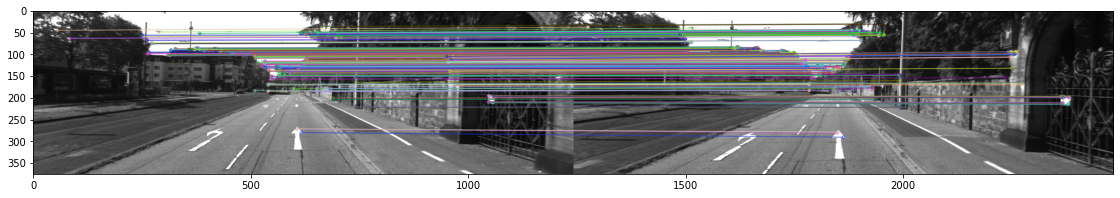

Keeping 102/353 points that match the fundamental matrix
45 102


[(CloudPoint(point_3d=array([-0.99049518, -0.37422467,  3.26289233]), point_2d_2=array([388.80004883,  89.85601044])),
  array([388.80004883,  88.12800598])),
 (CloudPoint(point_3d=array([ 0.46051236,  0.35507085, -6.41975502]), point_2d_2=array([559.87207031, 132.7104187 ])),
  array([559.87207031, 130.63682556])),
 (CloudPoint(point_3d=array([-0.96919436, -0.35795232,  3.09505307]), point_2d_2=array([383.61605835,  89.16481018])),
  array([383.61605835,  87.09120941])),
 (CloudPoint(point_3d=array([-1.10645862, -0.44786069,  4.0120654 ]), point_2d_2=array([410.57290649,  92.06786346])),
  array([410.57290649,  89.57954407])),
 (CloudPoint(point_3d=array([-1.00954962, -0.37525394,  3.36548965]), point_2d_2=array([393.12002563,  92.16000366])),
  array([393.12002563,  90.72000122])),
 (CloudPoint(point_3d=array([-1.14876347, -0.50257288,  4.29218668]), point_2d_2=array([416.44802856,  88.12800598])),
  array([416.44802856,  86.40000916])),
 (CloudPoint(point_3d=array([-1.24076776, -0.5

In [83]:
# I made this part up, although it's an amalgamation of code from above which came from other places
points2_new, points3, matches, _ = detect_matches_and_E(img2, img3)

points3_valid = []

for i in range(len(points3)):
	point2 = points2_new[i, :]
	point3 = points3[i, :]

	for cp in point_cloud:
		if np.array_equal(point2, cp.point_2d_2):
			points3_valid.append((cp, point3))
			break

print(len(points3_valid), len(points3))

points3_valid

	

	

# points2_new = np.array(imgpts2)
# points3 = np.array(imgpts3)

# F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 10000000)
# E = K.T @ F @ K
# print("E:", E)

# print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")
# points1 = points1[status_mask[:, 0]]
# points2 = points2[status_mask[:, 0]]



In [86]:
success, rvec, t, inliers = cv2.solvePnPRansac(np.array([cp.point_3d for cp, point3 in points3_valid]), np.array([point3 for cp, point3 in points3_valid]), K, None)
assert success, "PnP failed!"

R, _ = cv2.Rodrigues(rvec)

P2 = np.hstack((R, t))
P, P1, P2

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[ 0.9566098 , -0.02692886,  0.29012502,  0.98949542],
        [-0.02712061, -0.99962652, -0.00336047, -0.01340091],
        [ 0.29010716, -0.00465371, -0.95698285,  0.14394178]]),
 array([[ 0.33599087, -0.92550719,  0.17477582, -0.69458992],
        [-0.93195308, -0.35353138, -0.08049231, -0.84495241],
        [ 0.13628495, -0.13583818, -0.98131259,  3.78419223]]))